## Scale with Dask

The [Planetary Computer Hub](http://planetarycomputer.microsoft.com/compute) is a JupyterHub paired with [Dask Gateway](https://gateway.dask.org/) for easily creating Dask clusters to distribute your computation on a cluster of machines.

### Creating a cluster

Use `dask_gateway.GatewayCluster` to quickly create a Dask cluster.

In [1]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(4)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.be77d5f48b9d4d98bc55a8f31d7421a1/status


Now that we've connected a client to the cluster, all computations using Dask will happen on our 4-worker cluster.

### Open the dashboard

The [Dask Dashboard](https://docs.dask.org/en/latest/diagnostics-distributed.html) provides invaluable information on the activity of your cluster. Clicking the "Dashboard" link above will open the Dask dashboard a new browser tab.

<img src="images/dashboard-tab.png" width="50%" alt="Dask Dashboard in a new tab."/>

We also include the [dask-labextension](https://github.com/dask/dask-labextension) for laying out the Dask dashboard as tabs in the Jupyterlab workspace.

<img src="images/dashboard-hub.png" width="50%" alt="Dask Dashboard in jupyterlab."/>

To using the dask-labextension, copy the "Dashboard" address from the cluster repr, click the orange Dask logo on the lefthand navigation bar, and paste the dashboard address 

You can close your cluster, freeing up its resources, by calling `cluster.close()`.

In [ ]:
cluster.close()

### Autoscale the cluster to your workload

Dask Clusters can [automatically adapt](https://docs.dask.org/en/latest/setup/adaptive.html) the cluster size based on the size of the workload. Use `cluster.adapt(minimum, maximum)` to enable adaptive mode.

In [3]:
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=2, maximum=50)

Dask will add workers as necessary when a computation is submitted. As an example, we'll compute the minimum daily temperature averaged over all of Hawaii, using the [Daymet dataset](http://aka.ms/ai4edata-daymet).

In [4]:
import pystac_client
import planetary_computer
import xarray as xr

account_name = "daymeteuwest"
container_name = "daymet-zarr"

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
asset = (
    catalog.get_collection("daymet-daily-hi")
    .assets["zarr-abfs"]
)

ds = xr.open_zarr(asset.href, **asset.extra_fields["xarray:open_kwargs"], storage_options=asset.extra_fields["xarray:storage_options"])
ds

<xarray.Dataset>
Dimensions:                  (time: 14965, y: 584, x: 284, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

The `.compute()` call in the next cell is what triggers computation and causes Dask to scale the cluster up to a dozen or so workers.

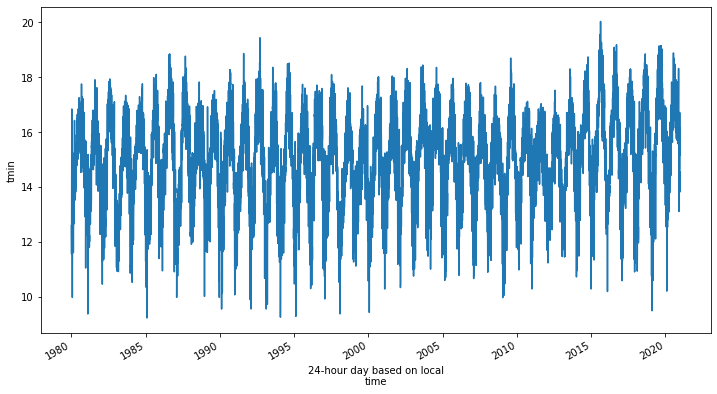

In [5]:
timeseries = ds["tmin"].mean(dim=["x", "y"]).compute()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
timeseries.plot(ax=ax);

In [6]:
cluster.close()

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


### Customize your cluster

`dask_gateway.GatewayCluster` creates a cluster with some default settings, which might not be appropriate for your workload. For example, we might have a memory-intensive worload which requires more memory per CPU core. Or we might need to set environment variables on the workers.

To customize your cluster, create a `Gateway` object and then customize the options.

In [7]:
import dask_gateway

gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()

<img src="images/cluster-options.png" width="35%" alt="Cluster options."/>

In a Jupyter Notebook, you can use the HTML widget to customize the options. Or using Python you can adjust the values programatically. We'll ask for 16GiB of memory per worker.

In [8]:
cluster_options["worker_memory"] = 16

Now create your cluster. **Make sure to pass the `cluster_options` object to  `gateway.new_cluster`**.

In [9]:
cluster = gateway.new_cluster(cluster_options)
client = cluster.get_client()
cluster.scale(2)

### Learn more

The [Dask documentation](https://docs.dask.org/en/latest/) has much more information on using Dask for scalable computing. This JupyterHub deployment uses [Dask Gateway](https://gateway.dask.org/) to manage creating Dask clusters.